# DIP-seq bioinformatics analysis of _Escherichia coli_

Here we use raw reads **wt (wild type)** of _Escherichia coli_ K-12 strain. \
The list of input files:
1. WT m6A/6mA Replicate 1 (R1),
2. WT m6A/6mA Replicate 2 (R2),
3. WT genomic DNA sequence / Control file.

## Quality control

In [7]:
# convert all .bz2 files to .gz format
# it is needed for further analysis
!cd /mnt/storage/lab12/k12 && for f in *.bz2; do bzcat "$f" | gzip -c >"${f%.*}.gz"; done

In [8]:
# prepare folder for fastqc reports
!cd /mnt/storage/lab12/k12 && mkdir fastqc_outputs

In [ ]:
# install fastqc via conda
conda install bioconda::fastqc

In [ ]:
# launch fastqc
!fastqc /mnt/storage/lab12/k12/*.fastq.gz -o /mnt/storage/lab12/k12/fastqc_outputs

**Fastqc html reports interpretation**

_before trimming:_

_WT subset:_

wt_m6A_1: 3,503,830 reads, \
wt_m6A_2: 3,628,333  reads, \
wt_E_Coli (Control file): 1,938,062 reads.

It seeems the num. of reads is enough (>=~1kk) for further analysis of ecoli.. \
proof: 'So even if you downsample your library to 1 million reads, it should still give you reliable results.' from: https://github.com/macs3-project/MACS/issues/353.

Failure in the following sections:
'Per sequence QC content' - ok (https://www.biostars.org/p/9540513/) \
'Per base sequence content' - it is ok for ChIP-seq analysis (https://www.biostars.org/p/9494902/).

## Data cleaning
i.e. reads trimming.

To remove low quality sequences we select the 2 most important parameters which are the minimum Phred score (1-30) and a minimum sequencing length.
There are different views on these parameters. A good estimate is typically a Phred score of 20 (99% confidence) (by default) and a minimum of 50-70% of the sequence length (let's choose 50% of the sequence length, e.g., 0.5 x 60 = 30 bp).

about Phred score: https://gatk.broadinstitute.org/hc/en-us/articles/360035531872-Phred-scaled-quality-scores.

p.s. In this case, the data are appropriate for further analysis without any trimming and cleaning procedures. Nonetheless, we show an example how to trim contaminated data correctly according to the rules described above.

In [14]:
# prepare folder for trimmed files
!mkdir /mnt/storage/lab12/k12/trimmed_files

In [ ]:
# install Trim Galore! (used for data trimming)
conda install bioconda::trim-galore

In [ ]:
# any raw input file 
!trim_galore \
{filename}.fastq.gz \
-o ./trimmed_files --fastqc \
--length 30 \
--quality 20

# option --fastqc allows to create a new fastqc report for already trimmed file.
# based on that, we may conclude is it appropriate for analysis or not.

## Reads mapping
i.e. obtain the coordinates of each read on reference genome.

DIP-seq data are mapped to reference genome using bowtie2.

We use reference genome of _E.coli_ strain K12: \
it can be downloaded here https://www.ncbi.nlm.nih.gov/data-hub/genome/GCF_000005845.2/ and saved as 'ecoli-k12_strain.fna'.

In [65]:
# how ref genome looks like
!cat ecoli-k12_strain.fna | head -n10

>NC_000913.3 Escherichia coli str. K-12 substr. MG1655, complete genome
AGCTTTTCATTCTGACTGCAACGGGCAATATGTCTCTGTGTGGATTAAAAAAAGAGTGTCTGATAGCAGCTTCTGAACTG
GTTACCTGCCGTGAGTAAATTAAAATTTTATTGACTTAGGTCACTAAATACTTTAACCAATATAGGCATAGCGCACAGAC
AGATAAAAATTACAGAGTACACAACATCCATGAAACGCATTAGCACCACCATTACCACCACCATCACCATTACCACAGGT
AACGGTGCGGGCTGACGCGTACAGGAAACACAGAAAAAAGCCCGCACCTGACAGTGCGGGCTTTTTTTTTCGACCAAAGG
TAACGAGGTAACAACCATGCGAGTGTTGAAGTTCGGCGGTACATCAGTGGCAAATGCAGAACGTTTTCTGCGTGTTGCCG
ATATTCTGGAAAGCAATGCCAGGCAGGGGCAGGTGGCCACCGTCCTCTCTGCCCCCGCCAAAATCACCAACCACCTGGTG
GCGATGATTGAAAAAACCATTAGCGGCCAGGATGCTTTACCCAATATCAGCGATGCCGAACGTATTTTTGCCGAACTTTT
GACGGGACTCGCCGCCGCCCAGCCGGGGTTCCCGCTGGCGCAATTGAAAACTTTCGTCGATCAGGAATTTGCCCAAATAA
AACATGTCCTGCATGGCATTAGTTTGTTGGGGCAGTGCCCGGATAGCATCAACGCTGCGCTGATTTGCCGTGGCGAGAAA
cat: ошибка записи: Обрыв канала


In [ ]:
# install bowtie2 aligner
conda install bioconda::bowtie2

In [ ]:
# indexing reference genome
# p.s. to perform bowtie2 alignment, it is required to index a genome.
!bowtie2-build ecoli-k12_strain.fna ecoli-k12_strain

In [43]:
## prepare folder for aligned reads
!mkdir /mnt/storage/lab12/k12/aligned_reads

In [ ]:
# mapping reads with bowtie2

# 1 - wt_m6A_1
!bowtie2 -p 8 -q --local -x ecoli-k12_strain \
-U /mnt/storage/lab12/k12/wt_m6A_1.fastq.gz \
-S /mnt/storage/lab12/k12/aligned_reads/wt_m6A_1_aln_unsorted.sam

In [ ]:
# 2 - wt_m6A_2
!bowtie2 -p 8 -q --local -x ecoli-k12_strain \
-U /mnt/storage/lab12/k12/wt_m6A_2.fastq.gz \
-S /mnt/storage/lab12/k12/aligned_reads/wt_m6A_2_aln_unsorted.sam

In [ ]:
# 3 - wt_E_Coli (control file)
!bowtie2 -p 8 -q --local -x ecoli-k12_strain \
-U /mnt/storage/lab12/k12/wt_E_Coli.fastq.gz \
-S /mnt/storage/lab12/k12/aligned_reads/wt_E_Coli_aln_unsorted.sam

p.s. an advice is here: it is better to perform a mapping procedure using any cluster if it is available. In this case, use .sh script (see more about entrypoint scripts) for multithreaded application support; this function allows you to make an aligning process faster.

## Reads filtering

In [1]:
## prepare folder for filtered reads
!mkdir /mnt/storage/lab12/k12/aligned_reads/filtered_reads

We want to get uniquely mapped reads only. For this, we should do the following steps:
1. Change file format from SAM to BAM,
2. Sort BAM file by genomic coordinates,
3. Filter uniquely mapping reads.

In [3]:
# change file format from SAM to BAM

# 1 - wt_m6A_1
!samtools view -h -S -b \
-o /mnt/storage/lab12/k12/aligned_reads/filtered_reads/wt_m6A_1_aln_unsorted.bam \
/mnt/storage/lab12/k12/aligned_reads/wt_m6A_1_aln_unsorted.sam

In [ ]:
# 2 - wt_m6A_2
!samtools view -h -S -b \
-o /mnt/storage/lab12/k12/aligned_reads/filtered_reads/wt_m6A_2_aln_unsorted.bam \
/mnt/storage/lab12/k12/aligned_reads/wt_m6A_2_aln_unsorted.sam

In [12]:
# 3 - wt_E_Coli
!samtools view -h -S -b \
-o /mnt/storage/lab12/k12/aligned_reads/filtered_reads/wt_E_Coli_aln_unsorted.bam \
/mnt/storage/lab12/k12/aligned_reads/wt_E_Coli_aln_unsorted.sam

In [21]:
# sort BAM file by genomic coordinates

# 1 - wt_m6A_1
!samtools sort \
-o /mnt/storage/lab12/k12/aligned_reads/filtered_reads/wt_m6A_1_aln_sorted.bam \
/mnt/storage/lab12/k12/aligned_reads/filtered_reads/wt_m6A_1_aln_unsorted.bam

In [ ]:
# 2 - wt_m6A_2
!samtools sort \
-o /mnt/storage/lab12/k12/aligned_reads/filtered_reads/wt_m6A_2_aln_sorted.bam \
/mnt/storage/lab12/k12/aligned_reads/filtered_reads/wt_m6A_2_aln_unsorted.bam

In [30]:
# 3 - wt_E_Coli
!samtools sort \
-o /mnt/storage/lab12/k12/aligned_reads/filtered_reads/wt_E_Coli_aln_sorted.bam \
/mnt/storage/lab12/k12/aligned_reads/filtered_reads/wt_E_Coli_aln_unsorted.bam

In [40]:
# filter uniquely mapping reads

# 1 - wt_m6A_1
!cd /mnt/storage/lab12/k12/aligned_reads/filtered_reads/ && samtools view -bq 1 \
wt_m6A_1_aln_sorted.bam > wt_m6A_1_aln.bam

In [ ]:
# 2 - wt_m6A_2
!cd /mnt/storage/lab12/k12/aligned_reads/filtered_reads/ && samtools view -bq 1 \
wt_m6A_2_aln_sorted.bam > wt_m6A_2_aln.bam

In [49]:
# 3 - wt_E_Coli
!cd /mnt/storage/lab12/k12/aligned_reads/filtered_reads/ && samtools view -bq 1 \
wt_E_Coli_aln_sorted.bam > wt_E_Coli_aln.bam

In [61]:
# create indices for all the bam files

# 1 - wt_m6A_1
!cd /mnt/storage/lab12/k12/aligned_reads/filtered_reads/ && samtools index \
wt_m6A_1_aln.bam

In [ ]:
# 2 - wt_m6A_2
!cd /mnt/storage/lab12/k12/aligned_reads/filtered_reads/ && samtools index \
wt_m6A_2_aln.bam

In [70]:
# 3 - wt_E_Coli
!cd /mnt/storage/lab12/k12/aligned_reads/filtered_reads/ && samtools index \
wt_E_Coli_aln.bam

## Peak calling

**Peak calling with MACS2**

Now that the alignment files contain only uniquely mapping reads, we are ready to perform peak calling.

Peak calling as the next step in the workflow is a computational method used to identify areas in the genome that
have been enriched with aligned reads as a consequence of performing a DIP-sequencing experiment.

MACS2 is one of the most commonly used peak finders.

p.s. MACS2 allows us to find the two types of peaks: broad and narrow. Broad are often associated with histone modifications in ChIP-seq experiments, while narrow ones are with transcription factors (TFs). Here we describe only a broad type of peaks parameter.

In [84]:
# prepare folder for outputs generated from MACS2
!mkdir /mnt/storage/lab12/k12/aligned_reads/filtered_reads/macs2_broad_peaks

In [ ]:
# install MACS2
conda install bioconda::macs2

In [ ]:
# launch macs2
# wt_m6A_1 - DIP-seq file (wt_E_Coli - control file) / broad peaks calling.
!cd /mnt/storage/lab12/k12/aligned_reads/filtered_reads/ && \
macs2 callpeak -t wt_m6A_1_aln.bam \
-c wt_E_Coli_aln.bam \
--format BAM --gsize 4641652 --name wt_m6A_1__wt_E_Coli --broad \
--nomodel --extsize 200 \
--outdir ./macs2_broad_peaks

In [123]:
!wc -l \
/mnt/storage/lab12/k12/aligned_reads/filtered_reads/macs2_broad_peaks/wt_m6A_1__wt_E_Coli_peaks.broadPeak

1272 /mnt/storage/lab12/k12/merged_files/aligned_reads/filtered_reads/macs2_broad_peaks/wt_m6A_1__wt_E_Coli_peaks.broadPeak


p.s. --gsize Effective genome size: this is the size of the genome considered 'usable' for peak calling. This value is given by the MACS developpers on their website. It is smaller than the complete genome because many regions are excluded (telomeres, highly repeated regions...). The default value is for human (2700000000.0), so we need to change it. As the value for _E. coli_ is not provided, we will take the complete genome size 4,641,652 bp.

--nomodel --extsize 200 were used to eliminate the lack of results. --extsize 200 was chosen according to the _E.coli_ article: https://www.microbiologyresearch.org/content/journal/mgen/10.1099/mgen.0.000833?crawler=true.

In [ ]:
# wt_m6A_2 - DIP-seq file (wt_E_Coli - control file) / broad peaks calling.
!cd /mnt/storage/lab12/k12/aligned_reads/filtered_reads/ && \
macs2 callpeak -t wt_m6A_2_aln.bam \
-c wt_E_Coli_aln.bam \
--format BAM --gsize 4641652 --name wt_m6A_2__wt_E_Coli --broad \
--nomodel --extsize 200 \
--outdir ./macs2_broad_peaks

In [125]:
!wc -l \
/mnt/storage/lab12/k12/aligned_reads/filtered_reads/macs2_broad_peaks/wt_m6A_2__wt_E_Coli_peaks.broadPeak

1266 /mnt/storage/lab12/k12/merged_files/aligned_reads/filtered_reads/macs2_broad_peaks/wt_m6A_2__wt_E_Coli_peaks.broadPeak


**Consensus peaks identification**

In [ ]:
# install deeptools
conda install bioconda::deeptools

In [144]:
!bedtools intersect \
-a /mnt/storage/lab12/k12/aligned_reads/filtered_reads/macs2_broad_peaks/wt_m6A_1__wt_E_Coli_peaks.broadPeak \
-b /mnt/storage/lab12/k12/aligned_reads/filtered_reads/macs2_broad_peaks/wt_m6A_2__wt_E_Coli_peaks.broadPeak \
> /mnt/storage/lab12/k12/aligned_reads/filtered_reads/macs2_broad_peaks/wt_m6A.bed

In [6]:
!wc -l \
/mnt/storage/lab12/k12/merged_files/aligned_reads/filtered_reads/macs2_broad_peaks/wt_m6A.bed

1182 /mnt/storage/lab12/k12/merged_files/aligned_reads/filtered_reads/macs2_broad_peaks/wt_m6A.bed


## Visualisation

**Heatmap and profile plot showing distribution of density reads across either genomic regions containing peaks (1 way) or genome (2 way)**

In [ ]:
# Bigwig files creation (deepTools package)
!bamCoverage \
--bam wt_E_Coli_aln.bam \
--outFileName wt_E_Coli_aln.bw \
--outFileFormat bigwig \
--effectiveGenomeSize 4641652 \
--normalizeUsing RPGC

In [ ]:
!bamCoverage \
--bam wt_m6A_1_aln.bam \
--outFileName wt_m6A_1_aln.bw \
--outFileFormat bigwig \
--effectiveGenomeSize 4641652 \
--normalizeUsing RPGC

In [ ]:
!bamCoverage \
--bam wt_m6A_2_aln.bam \
--outFileName wt_m6A_2_aln.bw \
--outFileFormat bigwig \
--effectiveGenomeSize 4641652 \
--normalizeUsing RPGC

In [ ]:
# Matrix file creation (1 way)
# WT m6A R1, WT m6A R2 reads vs
# methyladenine consensus peaks
# (deepTools package)
!computeMatrix reference-point \
--referencePoint center \
-S wt_m6A_1_aln.bw wt_m6A_2_aln.bw \
-R wt_m6A.bed \
--beforeRegionStartLength 3000 \
--afterRegionStartLength 3000 \
-o peaks_matrix_centering.mat.gz -p 8

In [ ]:
# Heatmaps creation
!plotHeatmap -m peaks_matrix_centering.mat.gz \
-out peaks_matrix_centering.png

In [ ]:
# Profile plots creation
!plotProfile -m peaks_matrix_centering.mat.gz \
-out peaks_matrix_centering_profile.png

In [ ]:
# convert gtf to bed
# gtf is retrieved from: 
# https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/005/845/GCF_000005845.2_ASM584v2/
# and saved as 'ecoli_k12.gtf'
!sortBed -i ecoli_k12.gtf | gff2bed > ecoli_k12.bed

# it is needed for scale-regions heatmap and profile plots formation

In [ ]:
# Matrix file creation (2 way)
# WT m6A R1, WT m6A R2 reads vs
# gene regions
# (deepTools package)
!computeMatrix scale-regions \
-S wt_m6A_1_aln.bw wt_m6A_2_aln.bw \
-R ecoli_k12.bed \
--beforeRegionStartLength 3000 \
--regionBodyLength 5000 \
--afterRegionStartLength 3000 \
-o peaks_matrix_genes.mat.gz -p 8

In [ ]:
!plotHeatmap -m peaks_matrix_genes.mat.gz \
-out peaks_matrix_genes.png

In [ ]:
!plotProfile -m peaks_matrix_genes.mat.gz \
-out peaks_matrix_genes_profile.png

In [ ]:
//

**Venn diagrams**

Venn diagrams illustrate the overlappings between dif. consensus peaks.

In [ ]:
# install package
!pip install matplotlib-venn

In [1]:
# import libraries

from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles
from matplotlib import pyplot as plt
%matplotlib inline 
# will create plots and store them within the notebook

_Broad peaks (WT m6A/6mA and S9.6 peaks)_

In [3]:
!wc -l /mnt/storage/lab12/k12/merged_files/aligned_reads/filtered_reads/macs2_broad_peaks/wt_m6A.bed 
# m6A/6mA

1182 /mnt/storage/lab12/k12/merged_files/aligned_reads/filtered_reads/macs2_broad_peaks/wt_m6A.bed


In [5]:
!wc -l /mnt/storage/lab12/k12/merged_files/aligned_reads/filtered_reads/macs2_broad_peaks/wt_S96.bed
# S9.6

848 /mnt/storage/lab12/k12/merged_files/aligned_reads/filtered_reads/macs2_broad_peaks/wt_S96.bed


In [6]:
!mkdir \
/mnt/storage/lab12/k12/merged_files/aligned_reads/filtered_reads/macs2_broad_peaks/intersections

In [7]:
!bedtools intersect \
-a /mnt/storage/lab12/k12/merged_files/aligned_reads/filtered_reads/macs2_broad_peaks/wt_m6A.bed \
-b /mnt/storage/lab12/k12/merged_files/aligned_reads/filtered_reads/macs2_broad_peaks/wt_S96.bed > \
/mnt/storage/lab12/k12/merged_files/aligned_reads/filtered_reads/macs2_broad_peaks/intersections/wt_m6A__wt_S96_intersections.bed

In [8]:
!wc -l \
/mnt/storage/lab12/k12/merged_files/aligned_reads/filtered_reads/macs2_broad_peaks/intersections/wt_m6A__wt_S96_intersections.bed

447 /mnt/storage/lab12/k12/merged_files/aligned_reads/filtered_reads/macs2_broad_peaks/intersections/wt_m6A__wt_S96_intersections.bed


In [9]:
1182 - 447

735

In [10]:
848 - 447

401

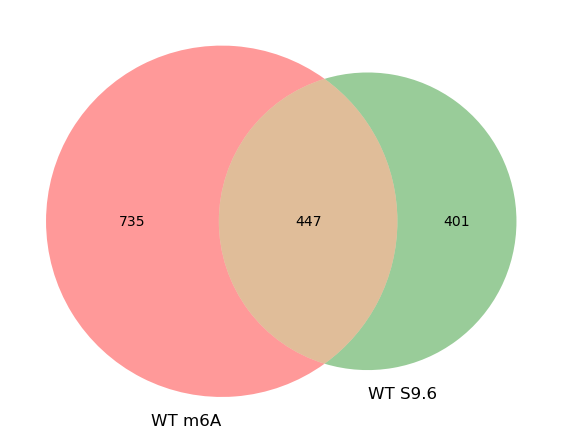

In [3]:
plt.rcParams["figure.figsize"] = [7,7]
venn2(subsets = (735, 401, 447), set_colors = ("red", "green"),
     set_labels = ("WT m6A", "WT S9.6"))
plt.show()